In [17]:
library(tidyverse)
library(broom)

In [4]:
set.seed(123)
n <- 2000

dados <- tibble(
  Disease = sample(c("Chikungunya", "Dengue"), n, replace = TRUE),
  Sex = sample(c("Male", "Female"), n, replace = TRUE),
  Age = sample(1:100, n, replace = TRUE),
  Diabetes = rbinom(n, 1, 0.2),
  Autoimmune = rbinom(n, 1, 0.05),
  Hematologic = rbinom(n, 1, 0.03),
  Liver = rbinom(n, 1, 0.04),
  Hypertension = rbinom(n, 1, 0.3),
  Kidney = rbinom(n, 1, 0.05)
)

In [6]:
head(dados)

Disease,Sex,Age,Diabetes,Autoimmune,Hematologic,Liver,Hypertension,Kidney
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Chikungunya,Male,52,0,0,0,0,1,0
Chikungunya,Male,37,0,0,0,0,0,0
Chikungunya,Male,71,1,0,0,0,1,0
Dengue,Female,31,0,0,0,0,1,0
Chikungunya,Female,31,0,0,0,0,0,0
Dengue,Male,50,1,1,0,0,1,0


In [9]:
dados <- dados %>%
  mutate(
    AgeGroup = cut(
      Age,
      breaks = c(0, 1, 9, 19, 39, 49, 59, 69, 79, 89, Inf),
      labels = c("<1", "1-9", "10-19", "20-39", "40-49", "50-59",
                 "60-69", "70-79", "80-89", "≥90"),
      right = FALSE
    ),
    Outcome = rbinom(n, 1, prob = plogis(
      -2 +
        0.3 * (Sex == "Male") +
        0.5 * (AgeGroup %in% c("70-79", "80-89", "≥90")) +
        0.6 * Diabetes +
        0.8 * Autoimmune +
        1.2 * Hematologic +
        0.7 * Liver +
        0.4 * Hypertension +
        1.1 * Kidney
    ))
  )
head(dados)

Disease,Sex,Age,Diabetes,Autoimmune,Hematologic,Liver,Hypertension,Kidney,AgeGroup,Outcome
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>
Chikungunya,Male,52,0,0,0,0,1,0,50-59,0
Chikungunya,Male,37,0,0,0,0,0,0,20-39,0
Chikungunya,Male,71,1,0,0,0,1,0,70-79,1
Dengue,Female,31,0,0,0,0,1,0,20-39,0
Chikungunya,Female,31,0,0,0,0,0,0,20-39,0
Dengue,Male,50,1,1,0,0,1,0,50-59,1


In [10]:
model <- function(x) {
  glm(
    Outcome ~ Sex + AgeGroup + Diabetes + Autoimmune + Hematologic +
      Liver + Hypertension + Kidney,
    data = filter(dados, Disease == x),
    family = binomial
  )
}

In [11]:
model_chik <- model("Chikungunya")
model_chik


Call:  glm(formula = Outcome ~ Sex + AgeGroup + Diabetes + Autoimmune + 
    Hematologic + Liver + Hypertension + Kidney, family = binomial, 
    data = filter(dados, Disease == x))

Coefficients:
  (Intercept)        SexMale  AgeGroup10-19  AgeGroup20-39  AgeGroup40-49  
      -2.3427         0.3562         0.4892         0.1445         0.4759  
AgeGroup50-59  AgeGroup60-69  AgeGroup70-79  AgeGroup80-89    AgeGroup≥90  
       0.7452         0.1409         0.8467         1.1360         0.9696  
     Diabetes     Autoimmune    Hematologic          Liver   Hypertension  
       0.8403         0.7854         1.1103         0.5611         0.2150  
       Kidney  
       0.8224  

Degrees of Freedom: 1020 Total (i.e. Null);  1005 Residual
Null Deviance:	    1109 
Residual Deviance: 1039 	AIC: 1071

In [12]:
model_dengue <- model("Dengue")
model_dengue


Call:  glm(formula = Outcome ~ Sex + AgeGroup + Diabetes + Autoimmune + 
    Hematologic + Liver + Hypertension + Kidney, family = binomial, 
    data = filter(dados, Disease == x))

Coefficients:
  (Intercept)        SexMale  AgeGroup10-19  AgeGroup20-39  AgeGroup40-49  
      -2.5317         0.7014         0.1076         0.2617         0.3403  
AgeGroup50-59  AgeGroup60-69  AgeGroup70-79  AgeGroup80-89    AgeGroup≥90  
       0.5705        -0.2963         1.3584         0.9173         0.7832  
     Diabetes     Autoimmune    Hematologic          Liver   Hypertension  
       0.3666         1.0710         1.7511         0.4462         0.4361  
       Kidney  
       1.3551  

Degrees of Freedom: 978 Total (i.e. Null);  963 Residual
Null Deviance:	    1055 
Residual Deviance: 952.5 	AIC: 984.5

In [14]:
extract_OR <- function(model, x) {
  tidy(model, conf.int = TRUE, exponentiate = TRUE) %>%
    filter(term != "(Intercept)") %>%
    mutate(Disease = x)
}

In [18]:
res_chik <- extract_OR(model_chik, "Chikungunya")
res_dengue <- extract_OR(model_dengue, "Dengue")

In [21]:
head(res_chik)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,Disease
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SexMale,1.427898,0.1554615,2.2912627,0.02194822,1.0539877,1.939696,Chikungunya
AgeGroup10-19,1.631057,0.3874985,1.2625295,0.20675831,0.7705998,3.551825,Chikungunya
AgeGroup20-39,1.155440,0.3583937,0.4031354,0.68684860,0.5820479,2.392390,Chikungunya
AgeGroup40-49,1.609461,0.3887603,1.2241468,0.22089687,0.7579551,3.511584,Chikungunya
AgeGroup50-59,2.106880,0.3735691,1.9948336,0.04606103,1.0280967,4.483451,Chikungunya
AgeGroup60-69,1.151327,0.4064244,0.3467185,0.72880284,0.5197234,2.584582,Chikungunya


In [20]:
head(res_dengue)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,Disease
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SexMale,2.0165016,0.1662594,4.2184936,2.459399e-05,1.4594018,2.802366,Dengue
AgeGroup10-19,1.1136452,0.4218611,0.2551517,7.986059e-01,0.4907170,2.594870,Dengue
AgeGroup20-39,1.2991164,0.3748511,0.6981021,4.851133e-01,0.6376481,2.798500,Dengue
AgeGroup40-49,1.4054288,0.4174985,0.8151945,4.149610e-01,0.6265691,3.254225,Dengue
AgeGroup50-59,1.7691256,0.4122493,1.3838359,1.664087e-01,0.7996400,4.066138,Dengue
AgeGroup60-69,0.7435732,0.4401505,-0.6731518,5.008507e-01,0.3130942,1.782588,Dengue


In [25]:
results <- bind_rows(res_chik, res_dengue) %>%
  mutate(
    term = gsub("Sex", "Sex: ", term),
    term = gsub("AgeGroup", "Age Group: ", term),
    term = gsub("Diabetes", "Diabetes", term),
    term = gsub("Autoimmune", "Autoimmune disease", term),
    term = gsub("Hematologic", "Hematological disease", term),
    term = gsub("Liver", "Liver disease", term),
    term = gsub("Hypertension", "Hypertension", term),
    term = gsub("Kidney", "Kidney disease", term),
    term = gsub("\\)", "", gsub("\\(", "", term)),
    term = gsub("\\: ", ": ", term)
  ) %>%
  rename(OR = estimate, CI_low = conf.low, CI_high = conf.high)
head(results, 20)

term,OR,std.error,statistic,p.value,CI_low,CI_high,Disease
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Sex: Male,1.427898,0.1554615,2.2912627,2.194822e-02,1.0539877,1.939696,Chikungunya
Age Group: 10-19,1.631057,0.3874985,1.2625295,2.067583e-01,0.7705998,3.551825,Chikungunya
Age Group: 20-39,1.155440,0.3583937,0.4031354,6.868486e-01,0.5820479,2.392390,Chikungunya
Age Group: 40-49,1.609461,0.3887603,1.2241468,2.208969e-01,0.7579551,3.511584,Chikungunya
Age Group: 50-59,2.106880,0.3735691,1.9948336,4.606103e-02,1.0280967,4.483451,Chikungunya
Age Group: 60-69,1.151327,0.4064244,0.3467185,7.288028e-01,0.5197234,2.584582,Chikungunya
Age Group: 70-79,2.331840,0.3766361,2.2479465,2.457960e-02,1.1310314,4.991251,Chikungunya
Age Group: 80-89,3.114437,0.3678700,3.0881786,2.013874e-03,1.5419093,6.571068,Chikungunya
Age Group: ≥90,2.637021,0.3652518,2.6547439,7.936864e-03,1.3122178,5.536264,Chikungunya


In [29]:
results_sep <- results %>%
  mutate(
    Variable = case_when(
      grepl("Age Group", term) ~ "Age Group",
      grepl("Sex", term) ~ "Sex",
      TRUE ~ "Comorbidity"
    ),
    Level = case_when(
      grepl("Age Group: ", term) ~ gsub("Age Group: ", "", term),
      grepl("Sex: ", term) ~ gsub("Sex: ", "", term),
      TRUE ~ term
    )
  )
head(results_sep)

term,OR,std.error,statistic,p.value,CI_low,CI_high,Disease,Variable,Level
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Sex: Male,1.427898,0.1554615,2.2912627,0.02194822,1.0539877,1.939696,Chikungunya,Sex,Male
Age Group: 10-19,1.631057,0.3874985,1.2625295,0.20675831,0.7705998,3.551825,Chikungunya,Age Group,10-19
Age Group: 20-39,1.155440,0.3583937,0.4031354,0.68684860,0.5820479,2.392390,Chikungunya,Age Group,20-39
Age Group: 40-49,1.609461,0.3887603,1.2241468,0.22089687,0.7579551,3.511584,Chikungunya,Age Group,40-49
Age Group: 50-59,2.106880,0.3735691,1.9948336,0.04606103,1.0280967,4.483451,Chikungunya,Age Group,50-59
Age Group: 60-69,1.151327,0.4064244,0.3467185,0.72880284,0.5197234,2.584582,Chikungunya,Age Group,60-69


In [30]:
order_vars <- results_sep %>%
  group_by(Variable, Level) %>%
  summarise() %>%
  arrange(
    match(Variable, c("Age Group", "Comorbidity", "Sex")),
    desc(Level)
  ) %>%
  mutate(
    label = ifelse(duplicated(Variable), paste0("   ", Level), Variable)
  )
head(order_vars)

`summarise()` has grouped output by 'Variable'. You can override using the `.groups` argument.


Variable,Level,label
<chr>,<chr>,<chr>
Age Group,≥90,Age Group
Age Group,80-89,80-89
Age Group,70-79,70-79
Age Group,60-69,60-69
Age Group,50-59,50-59
Age Group,40-49,40-49


In [31]:
results_sep <- results_sep %>%
  left_join(order_vars, by = c("Variable", "Level"))
results_sep

term,OR,std.error,statistic,p.value,CI_low,CI_high,Disease,Variable,Level,label
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
Sex: Male,1.4278976,0.1554615,2.2912627,2.194822e-02,1.0539877,1.939696,Chikungunya,Sex,Male,Sex
Age Group: 10-19,1.6310570,0.3874985,1.2625295,2.067583e-01,0.7705998,3.551825,Chikungunya,Age Group,10-19,10-19
Age Group: 20-39,1.1554400,0.3583937,0.4031354,6.868486e-01,0.5820479,2.392390,Chikungunya,Age Group,20-39,20-39
Age Group: 40-49,1.6094614,0.3887603,1.2241468,2.208969e-01,0.7579551,3.511584,Chikungunya,Age Group,40-49,40-49
Age Group: 50-59,2.1068801,0.3735691,1.9948336,4.606103e-02,1.0280967,4.483451,Chikungunya,Age Group,50-59,50-59
Age Group: 60-69,1.1513266,0.4064244,0.3467185,7.288028e-01,0.5197234,2.584582,Chikungunya,Age Group,60-69,60-69
Age Group: 70-79,2.3318401,0.3766361,2.2479465,2.457960e-02,1.1310314,4.991251,Chikungunya,Age Group,70-79,70-79
Age Group: 80-89,3.1144370,0.3678700,3.0881786,2.013874e-03,1.5419093,6.571068,Chikungunya,Age Group,80-89,80-89
Age Group: ≥90,2.6370210,0.3652518,2.6547439,7.936864e-03,1.3122178,5.536264,Chikungunya,Age Group,≥90,Age Group


Warning message:
“Removed 2 rows containing missing values (`geom_errorbarh()`).”


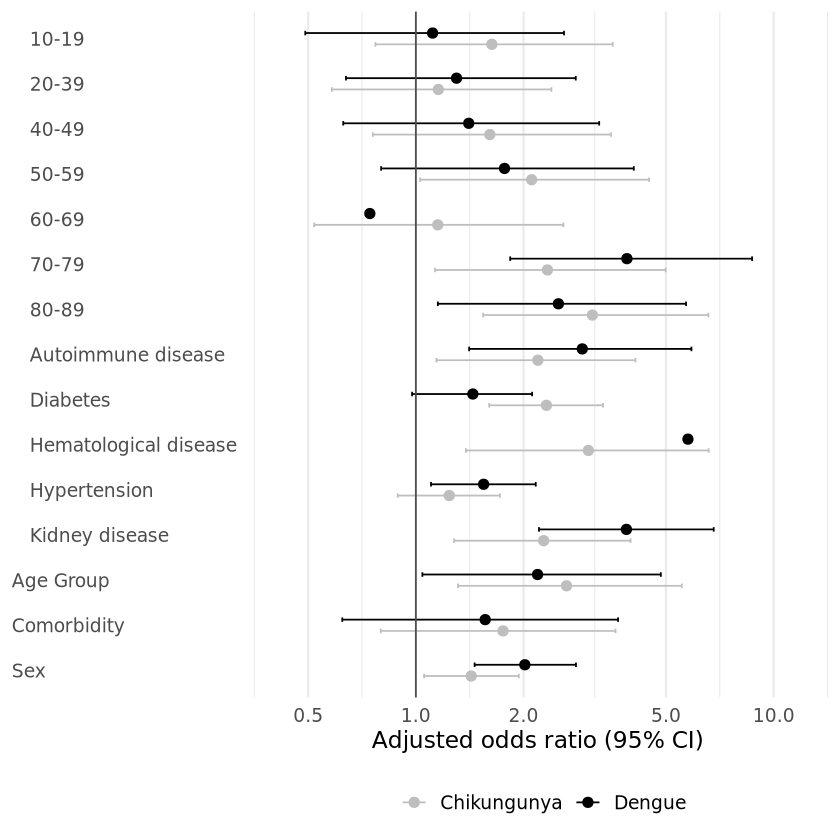

In [34]:
ggplot(results_sep, aes(x = OR, y = fct_rev(label), color = Disease)) +
  geom_point(position = position_dodge(width = 0.5), size = 2.5) +
  geom_errorbarh(aes(xmin = CI_low, xmax = CI_high),
                 position = position_dodge(width = 0.5),
                 height = 0.2) +
  geom_vline(xintercept = 1, linetype = "solid", color = "gray30") +
  scale_x_log10(breaks = c(0.5, 1, 2, 5, 10), limits = c(0.4, 12)) +
  scale_color_manual(values = c("Chikungunya" = "gray", "Dengue" = "black")) +
  labs(
    x = "Adjusted odds ratio (95% CI)",
    y = NULL,
    color = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y = element_text(hjust = 0),
    panel.grid.major.y = element_blank(),
    legend.position = "bottom"
  )